# Pre-Analysis of SL System SDSS1206+4332
This notebook takes the drizzled HST images and extracts the information (e.g. cutout of image, PSF and noise estimates) to be used in the subsequent modelling process.

### import libraries

In [1]:
import numpy as np
import os
import h5py

import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

### read in data from fits files

In [2]:
system_name = 'SDSS1206+4332'

ra_str = '12:06:29.72'
dec_str = '+43:32:19'

system = StrongLensSystem(system_name)
system.add_info_attribute('ra_str', ra_str)
system.add_info_attribute('dec_str', dec_str)

image_name = 'F160W'
image_filename = 'SDSS1206+4332_F160W_sci.fits'
wht_filename = "SDSS1206+4332_F160W_wht.fits"
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

# import the data
local_filename = os.path.join(base_path, 'Data', 'HST', image_filename)
local_wht_filename = os.path.join(base_path, 'Data', 'HST', wht_filename)


# add image data instance (see astroObjectAnalyser)
# options for cutout
numPix = 140 # only even numbers allowed so far
system.add_image_data_init(image_name, local_filename=local_filename, local_psf_filename=None, 
                    local_wht_filename=local_wht_filename,
                       ra=system.ra, dec=system.dec, ra_cutout_cent=system.ra, dec_cutout_cent=system.dec,
                       cutout_scale=numPix, data_type='HST_new')

print(system.ra, system.dec)
print(system.ra_str, system.dec_str)

/Users/sibirrer/Science/Projects/LensModelling/SDSS1206/Public
181.6238333333333 43.53861111111111
12:06:29.72 +43:32:19


## show image and determine shift and positions of point sources

the center of the image is at pixel coordinates 1209.915186, 1347.451680.


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


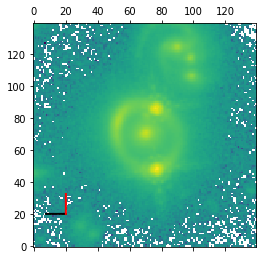

In [3]:

data_cutout = system.get_cutout_image(image_name, numPix, force=True)  # if force=True, a new cutout with the new options will be made

#%matplotlib notebook

plt.matshow(np.log10(data_cutout), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
plt.show()


0.08000002467604288
ccd gain = 2.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/sibirrer/Science/Projects/LensModelling/SDSS1206/Public/Data/HST/SDSS1206+4332_F160W_sci.fits -c .pysex.sex -GAIN 21142.223039999993 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
0.0 0.005417047534138
2.5
the center of the image is at pixel coordinates 1209.915186, 1347.451680.
separate exposure map loaded


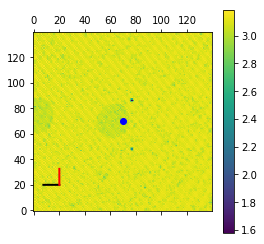

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10


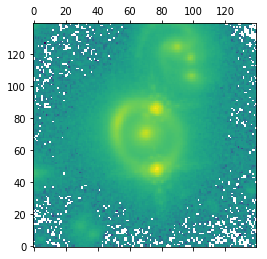

In [4]:
deltaPix, _ = system.get_pixel_scale(image_name)
deltaPix *= 3600  # convert into arcsec
print(deltaPix)
# get mean and sigma_bkd of image (computed by SourceExtractor)
mean, sigma_b = system.get_background(image_name)
ccd_gain = system.get_CCD_gain(image_name)
print(mean, sigma_b)
print(ccd_gain)

# we subtract the mean background estimate from the cutout image
data_reduced = (data_cutout - mean)#*mask_off


# get exposure time
exp_time = system.get_exposure_time(image_name)

# here we set the coordinate grid (rectangular)
ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(image_name)
x_at_radec_0, y_at_radec_0 = system.pixel_at_angle_0(image_name)
Matrix = system.get_transform_matrix_angle2pix(image_name)
Matrix_inv = system.get_transform_matrix_pix2angle(image_name)
cos_dec = np.cos(system.dec/360*2*np.pi)


# get weight map (effective exposure time per pixel)
wht_map = system.get_exposure_map(image_name)
# untis in pixels are originally electrons/s
# we estimate the Poisson noise term in respect to a smaller IID count rate
wht_map /= 2.5 # 2.5 is equivalent to the CCD_gain parameter
# for numerics, replace 0 with small number
wht_map[wht_map <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times


plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
 
x_0, y_0 = system.pixel_at_angle_0(image_name)
plt.plot(x_0, y_0, 'ob')
plt.colorbar()
plt.show()



plt.matshow(np.log10(data_reduced), origin='lower')
plt.show()



In [5]:
# save data configurations ih hdf5 format
data_filename = 'data.hdf5'
local_data_filename = os.path.join(base_path, 'Data', 'HST', data_filename)
f = h5py.File(local_data_filename, "w")
dset = f.create_dataset('image_data', data=data_reduced)
dset = f.create_dataset('background_rms', data=sigma_b)
dset = f.create_dataset('exposure_map', data=wht_map)
dset = f.create_dataset('ra_at_xy_0', data=ra_at_xy_0)
dset = f.create_dataset('dec_at_xy_0', data=dec_at_xy_0)
dset = f.create_dataset('transform_pix2angle', data=Matrix_inv)
f.close()

### PSF estimate

No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/sibirrer/Science/Projects/LensModelling/SDSS1206/Public/Data/HST/SDSS1206+4332_F160W_sci.fits -c .pysex.sex -GAIN 21142.223039999993 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
{'MagMaxThresh': 26.35067138671875, 'MagMinThresh': 23.0723876953125, 'SizeMinThresh': 0.4039413332939148, 'SizeMaxThresh': 4.403941333293915, 'EllipticityThresh': 0.1, 'ClassStarMax': 1.0, 'ClassStarMin': 0.5}
35 number of stars


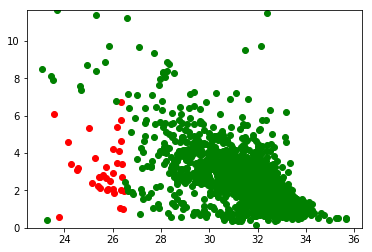

In [6]:
# options for PSF
psf_type ='pixel'
psf_size = 61
psf_size_large = 61
psf_symmetry = 4

# get SExtractor catalog
analysis = Analysis()
cat = system.get_cat(image_name)
#HDUFile, _ = system.get_HDUFile(image_name)
#import astropy.io.fits as pyfits
#HDUFile.writeto('pysex.cat')
#print HDUFile[2].data['X_WORLD']
#pyfits.writeto(filename='HDUFile.fits', data=HDUFile)
#print system.get_header(image_name)

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.8
kwargs_cuts['MagMinThresh'] = 22
kwargs_cuts['MagMaxThresh'] = 26.5
kwargs_cuts['SizeMinThresh'] = 0.5
kwargs_cuts['SizeMaxThresh'] = 7
mask = analysis.find_objects(cat, kwargs_cuts)
print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()


max iteration reached! stoping
-11.76458635693073 reduced X^2 of best position
max iteration reached! stoping
-70600.8252971216 reduced X^2 of best position
max iteration reached! stoping
-75.60523278285343 reduced X^2 of best position
max iteration reached! stoping
-67979.588968678 reduced X^2 of best position
max iteration reached! stoping
-78.28169150329528 reduced X^2 of best position
max iteration reached! stoping
-875.683540595577 reduced X^2 of best position
max iteration reached! stoping
-12062.836701289118 reduced X^2 of best position
max iteration reached! stoping
-7266.087476575483 reduced X^2 of best position
max iteration reached! stoping
-16465.747842015797 reduced X^2 of best position
max iteration reached! stoping
-10797.340462189319 reduced X^2 of best position
max iteration reached! stoping
-9399.690994938468 reduced X^2 of best position
max iteration reached! stoping
-9105.686312781929 reduced X^2 of best position
max iteration reached! stoping
-10354.9442298566 redu

/Users/sibirrer/Software/AstroObjectAnalyser/astroObjectAnalyser/DataAnalysis/analysis.py:69: RuntimeWarning: invalid value encountered in log10
  im = ax1.matshow(np.log10(sym_shifted), origin='lower', vmax=vmax, vmin=vmin)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


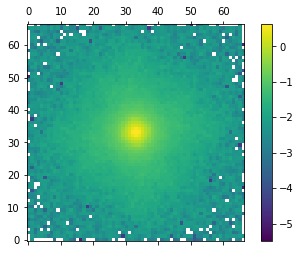

=== object === 1 -10.818845514826714 -19.995357121088432


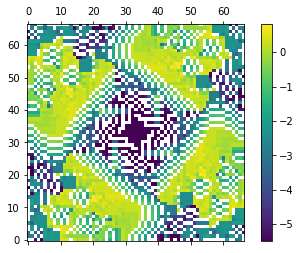

=== object === 2 -1.4804668951849047 -0.885151585641976


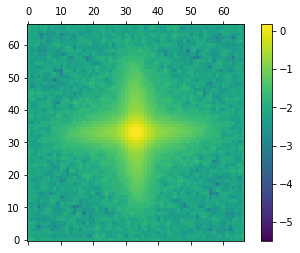

=== object === 3 17.075647870193393 -2.9503863495537357


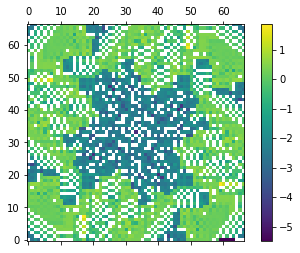

=== object === 4 -0.49765875111425334 -1.2139082901132139


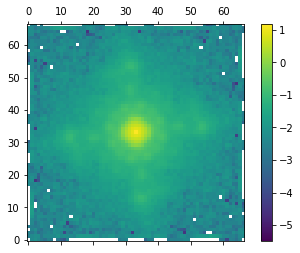

=== object === 5 -0.2002501255809277 -0.7509524794422915


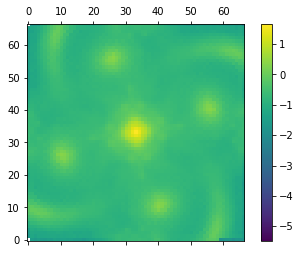

=== object === 6 -7.046021060625505 -56.49559287185381


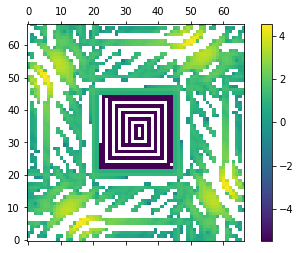

=== object === 7 -0.8626498842049355 -0.32432777785289213


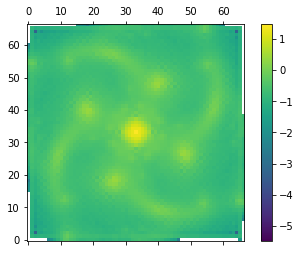

=== object === 8 15.950621472765171 2.380500736504197


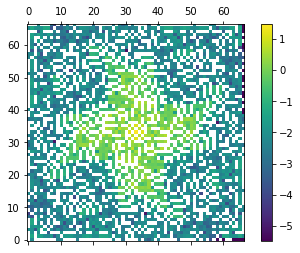

=== object === 9 -0.8436429770006119 -11.553676043697779


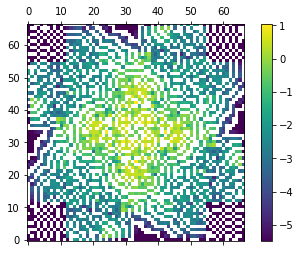

=== object === 10 -1.9153681285967703 -7.765392561469288


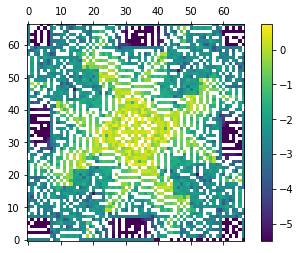

=== object === 11 -4.294442708877194 5.103929350295398


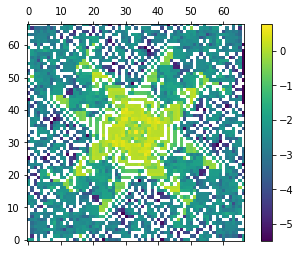

=== object === 12 -1.1485873391941401 -7.2463526613830185


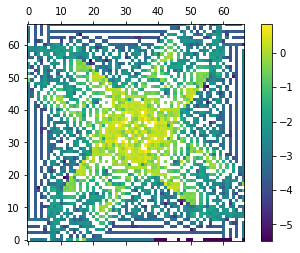

=== object === 13 -4.410376191957388 5.950349409876628


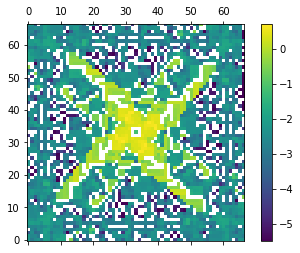

=== object === 14 -2.803974868087006 -7.725630698723962


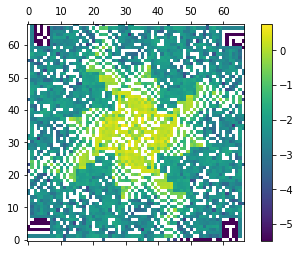

=== object === 15 -4.372534441293143 4.517017151365009


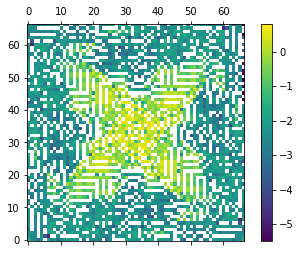

=== object === 16 -0.5072676449797422 -0.9996507021243853


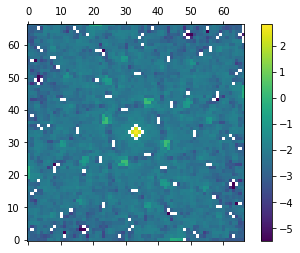

=== object === 17 -6.7952577477451195 -0.4132835630580646


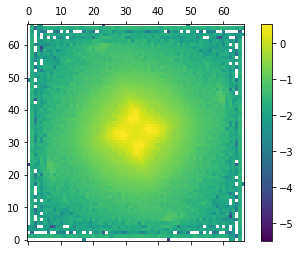

=== object === 18 -4.579600331062915 -6.578312545946043


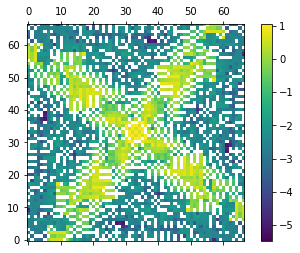

=== object === 19 2.442878010018021 11.083501309723703


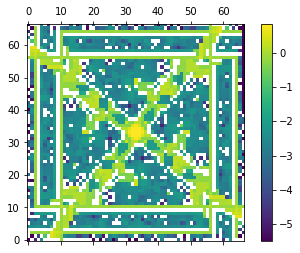

=== object === 20 -4.73720877925098 -6.88850861178349


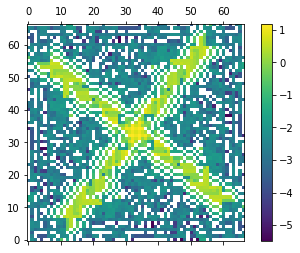

=== object === 21 0.13845497816247576 -0.9296942352411328


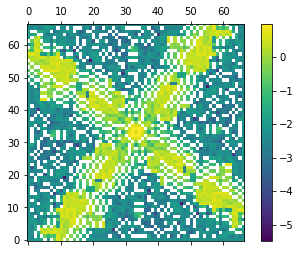

=== object === 22 -1.478975928476861 -0.6975987761478263


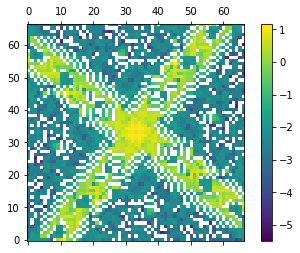

=== object === 23 -8.867784276793 -10.711688711523724


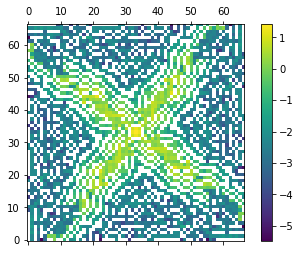

=== object === 24 -0.8111174917904045 -0.9941681957977355


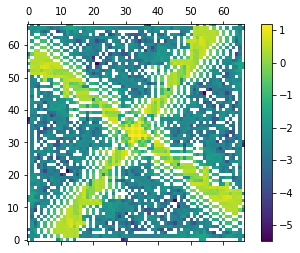

=== object === 25 -0.8991406470883074 -0.4498784938451016


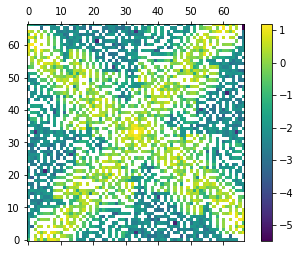

=== object === 26 -4.933430038084343 -6.045205802438834


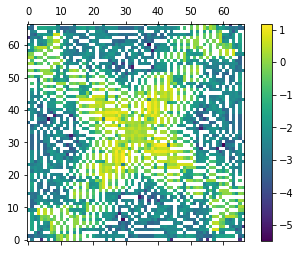

=== object === 27 3.7715941697385964 5.979542873744042


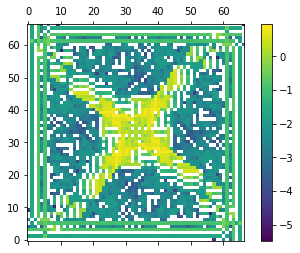

=== object === 28 6.104350321487233 8.274775557400469


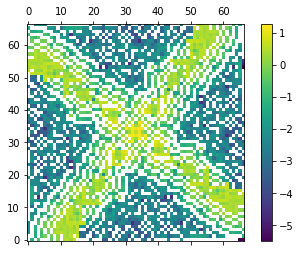

=== object === 29 4.924844428070964 -43.5715338609164


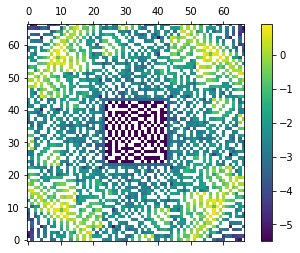

=== object === 30 -0.9700707196812804 0.05921915471539629


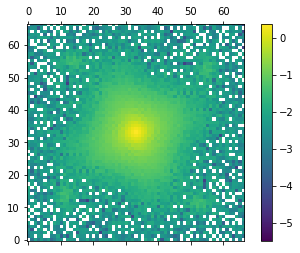

=== object === 31 -0.28289007081800366 -0.956586869178035


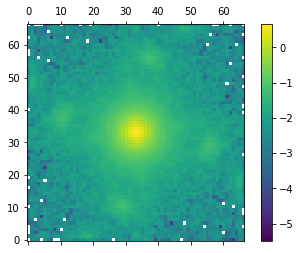

=== object === 32 -1.0630297074815138 -0.3259709994616333


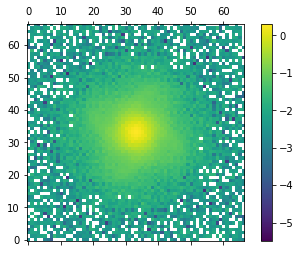

=== object === 33 -0.8191024188512883 -0.33725983761517975


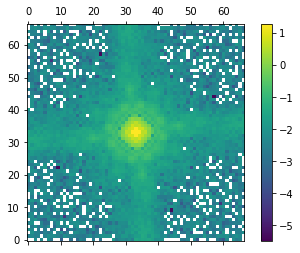

=== object === 34 -0.9535937036489488 -0.3648596611697059


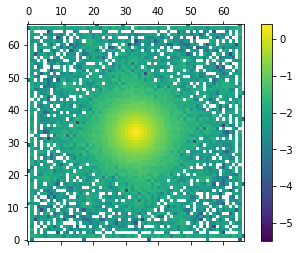

max iteration reached! stoping
-11.75380834062407 reduced X^2 of best position
max iteration reached! stoping
-57677.14369457522 reduced X^2 of best position
max iteration reached! stoping
-75.61518630677675 reduced X^2 of best position
max iteration reached! stoping
-52068.63163474821 reduced X^2 of best position
max iteration reached! stoping
-77.56217899469289 reduced X^2 of best position
max iteration reached! stoping
-876.4635813644479 reduced X^2 of best position
max iteration reached! stoping
-13990.313572390503 reduced X^2 of best position
max iteration reached! stoping
-7347.123531693557 reduced X^2 of best position
max iteration reached! stoping
-16481.425643054285 reduced X^2 of best position
max iteration reached! stoping
-12153.075508056445 reduced X^2 of best position
max iteration reached! stoping
-9372.176313241847 reduced X^2 of best position
max iteration reached! stoping
-9083.19461225457 reduced X^2 of best position
max iteration reached! stoping
-10361.522476600101

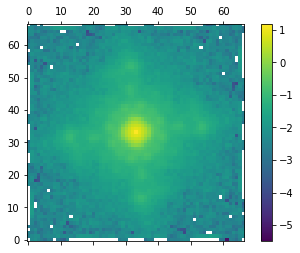

=== object === 33 -0.822076801657262 -0.3428967503059862


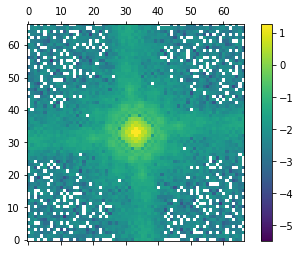

In [7]:
image_full = system.get_full_image(image_name)
image_full -= mean
kernel, mean_list, restrict_psf, star_list = analysis.get_psf(image_full, cat, mean, rms=sigma_b, poisson=exp_time,
                                psf_type='moffat', restrict_psf=None, kwargs_cut=kwargs_cuts, symmetry=psf_symmetry)

# restict psf fitting to subset of selected sources
#true_list = [17,21, 35]
true_list = [4, 33]
for i in range(len(restrict_psf)):
    if i not in true_list:
        restrict_psf[i] = False
kernel, mean_list, restrict_psf, star_list_shifted = analysis.get_psf(image_full, cat, mean, rms=sigma_b,
                                poisson=exp_time, psf_type='moffat', restrict_psf=restrict_psf, kwargs_cut=kwargs_cuts
                                                                     , symmetry=psf_symmetry)


1.0


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


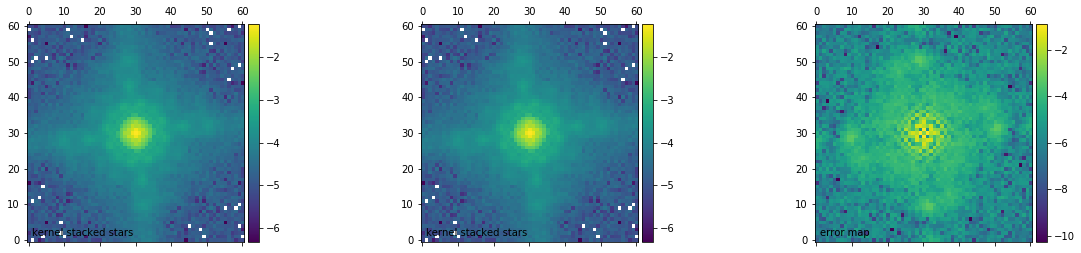

In [8]:
kernel_large_stack = kernel_util.cut_psf(kernel, psf_size=psf_size_large)
kernel_large_pixel = kernel #util.pixel_kernel(kernel)
kernel_pixel = kernel_util.cut_psf(kernel_large_pixel, psf_size=psf_size)
print(np.sum(kernel_large_stack))
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapelets = ShapeletSet()

kernel_list = shapelets.shapelet_basis_2d(num_order=10, beta=2, numPix=psf_size_large)
kernel_list.append(kernel_large_stack)
error_map = analysis.get_psf_errors(kernel_large_stack, sigma_b, star_list_shifted)


f, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
im = ax.matshow(np.log10(kernel_large_stack), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(kernel_pixel), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(np.log10(error_map), origin='lower')
ax.text(1, 1, 'error map')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [10]:
psf_filename = 'psf.hdf5'
local_psf_filename = os.path.join(base_path, 'Data', 'HST', psf_filename)
f = h5py.File(local_psf_filename, "w")
dset = f.create_dataset('kernel_point_source', data=kernel_large_stack)
dset = f.create_dataset('psf_error_map', data=error_map)
f.close()
